The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Memória Longa de Curto Prazo (LSTM)
:label:`sec_lstm`

O desafio de abordar a preservação de informações de longo prazo e entrada de curto prazo pulando
modelos de variáveis latentes existem há muito tempo. Uma das primeiras abordagens para resolver isso
foi a longa memória de curto prazo (LSTM) :cite:`Hochreiter.Schmidhuber.1997`. Ele compartilha muitos dos
as propriedades da GRU. Curiosamente, os LSTMs têm um design um pouco mais complexo do que os GRUs
mas antecede GRUs em quase duas décadas.

## Célula de Memória Bloqueada

Indiscutivelmente, o design da LSTM é inspirado
pelas portas lógicas de um computador.
LSTM introduz uma *célula de memória* (ou *célula* para abreviar)
que tem a mesma forma que o estado oculto
(algumas literaturas consideram a célula de memória
como um tipo especial de estado oculto),
projetado para registrar informações adicionais.
Para controlar a célula de memória
precisamos de vários portões.
Um portão é necessário para ler as entradas do
célula.
Vamos nos referir a isso como o
*portão de saída*.
Uma segunda porta é necessária para decidir quando ler os dados para o
célula.
Chamamos isso de *porta de entrada*.
Por último, precisamos de um mecanismo para redefinir
o conteúdo da célula, governado por um *portão de esquecimento*.
A motivação para tal
design é o mesmo das GRUs,
ou seja, ser capaz de decidir quando lembrar e
quando ignorar entradas no estado oculto por meio de um mecanismo dedicado. Deixe-nos ver
como isso funciona na prática.

### Porta de entrada, porta de esquecimento e porta de saída

Assim como em GRUs,
os dados que alimentam as portas LSTM são
a entrada na etapa de tempo atual e
o estado oculto da etapa de tempo anterior,
conforme ilustrado em :numref:`lstm_0`.
Eles são processados por
três camadas totalmente conectadas com uma função de ativação sigmóide para calcular os valores de
a entrada, esqueça. e portas de saída.
Como resultado, os valores das três portas
estão na faixa de $(0, 1)$.

![Calculando a porta de entrada, a porta de esquecimento e a porta de saída em um modelo LSTM.](../img/lstm-0.svg)
:label:`lstm_0`

Matematicamente,
suponha que existam $h$ unidades ocultas, o tamanho do lote é $n$ e o número de entradas é $d$.
Assim, a entrada é $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ e o estado oculto da etapa de tempo anterior é $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Correspondentemente, as portas na etapa de tempo $t$
são definidos da seguinte forma: a porta de entrada é $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, a porta de esquecimento é $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, e a porta de saída é $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. Eles são calculados da seguinte forma:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

onde $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ e $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ são parâmetros de pesos e $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ são parâmetros viéses.

### Célula de Memória Candidata

Em seguida, projetamos a célula de memória. Como ainda não especificamos a ação das várias portas, primeiro introduzimos a célula de memória *candidata* $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$. Seu cálculo é semelhante ao das três portas descritas acima, mas usando uma função $\tanh$ com um intervalo de valores para $(-1,1)$ como a função de ativação. Isso leva à seguinte equação na etapa de tempo $t$:

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

onde $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ são parâmetros de pesos $\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ é um parâmetro de viés.

Uma ilustração rápida da célula de memória candidata é mostrada em :numref:`lstm_1`.

![Computando a célula de memória candidata em um modelo LSTM.](../img/lstm-1.svg)
:label:`lstm_1`

### Célula de Memória

Em GRUs, temos um mecanismo para controlar a entrada e o esquecimento (ou salto).
De forma similar,
em LSTMs, temos duas portas dedicadas para tais propósitos: a porta de entrada $\mathbf{I}_t$ governa o quanto levamos os novos dados em conta via $\tilde{\mathbf{C}}_t$ e a porta de esquecer $\mathbf{F}_t$ aborda quanto do conteúdo da célula de memória antiga $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ retemos. Usando o mesmo truque de multiplicação pontual de antes, chegamos à seguinte equação de atualização:

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

Se a porta de esquecimento é sempre aproximadamente 1 e a porta de entrada é sempre aproximadamente 0, as células de memória anteriores $\mathbf{C}_{t-1}$ serão salvas ao longo do tempo e passadas para o intervalo de tempo atual.
Este projeto é introduzido para aliviar o problema do gradiente de desaparecimento e para melhor capturar
dependências de longo alcance dentro de sequências.

Assim, chegamos ao diagrama de fluxo em :numref:`lstm_2`.

![Calculando a célula de memória em um modelo LSTM.](../img/lstm-2.svg)

:label:`lstm_2`


### Estado Oculto

Por último, precisamos definir como calcular o estado oculto $\mathbf{H}_t \in \mathbb{R}^{n \times h}$. É aqui que a porta de saída entra em ação. No LSTM, é simplesmente uma versão bloqueada do $\tanh$ da célula de memória.
Isso garante que os valores de $\mathbf{H}_t$ estejam sempre no intervalo $(-1,1)$.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

Sempre que a porta de saída se aproxima de 1, passamos efetivamente todas as informações da memória para o preditor, enquanto para a porta de saída próxima de 0, retemos todas as informações apenas dentro da célula de memória e não realizamos nenhum processamento posterior.

:numref:`lstm_3` tem uma ilustração gráfica do fluxo de dados.

![Calculando o estado oculto em um modelo LSTM.](../img/lstm-3.svg)
:label:`lstm_3`



## Implementação do zero

Agora, vamos implementar um LSTM do zero.
Da mesma forma que os experimentos em :numref:`sec_rnn_scratch`,
primeiro carregamos o conjunto de dados da máquina do tempo.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Inicializando os parâmetros do modelo

Em seguida, precisamos definir e inicializar os parâmetros do modelo. Como anteriormente, o hiperparâmetro `num_hiddens` define o número de unidades ocultas. Inicializamos os pesos seguindo uma distribuição gaussiana com desvio padrão de 0,01 e definimos os vieses como 0.


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Definindo o modelo

Na função de inicialização, o estado oculto do LSTM precisa retornar uma célula de memória *adicional* com um valor de 0 e uma forma de (tamanho do lote, número de unidades ocultas). Consequentemente, obtemos a seguinte inicialização de estado.


In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

O modelo real é definido exatamente como o que discutimos antes: fornecer três portas e uma célula de memória auxiliar. Observe que apenas o estado oculto é passado para a camada de saída. A célula de memória $\mathbf{C}_t$ não participa diretamente no cálculo de saída.


In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### Treinamento e previsão

Vamos treinar um LSTM da mesma forma que fizemos em :numref:`sec_gru`, instanciando a classe `RNNModelScratch` como introduzida em :numref:`sec_rnn_scratch`.


perplexity 1.1, 20015.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e


travelleryou can show black is white by argument said filby


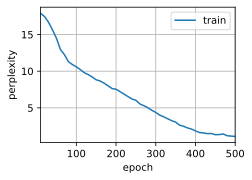

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Implementação concisa

Usando APIs de alto nível,
podemos instanciar diretamente um modelo `LSTM`.
Isso encapsula todos os detalhes de configuração que tornamos explícitos acima. O código é significativamente mais rápido, pois usa operadores compilados em vez de Python para muitos detalhes que explicamos em detalhes antes.


perplexity 1.1, 282016.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e


traveller with a slight accession ofcheerfulness really thi


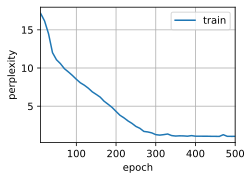

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

LSTMs são o modelo autorregressivo de variável latente prototípica com controle de estado não trivial.
Muitas variantes foram propostas ao longo dos anos, por exemplo, camadas múltiplas, conexões residuais, diferentes tipos de regularização. No entanto, treinar LSTMs e outros modelos de sequência (como GRUs) são bastante caros devido à dependência de longo alcance da sequência.
Mais tarde, encontraremos modelos alternativos, como transformadores, que podem ser usados em alguns casos.


## Resumo

* Os LSTMs têm três tipos de portas: portas de entrada, portas de esquecimento e portas de saída que controlam o fluxo de informações.
* A saída da camada oculta do LSTM inclui o estado oculto e a célula de memória. Apenas o estado oculto é passado para a camada de saída. A célula de memória é totalmente interna.
* LSTMs podem aliviar gradientes que desaparecem e explodem.



## Exercícios

1. Ajuste os hiperparâmetros e analise sua influência no tempo de execução, perplexidade e sequência de saída.
1. Como você precisaria mudar o modelo para gerar palavras adequadas em vez de sequências de caracteres?
1. Compare o custo computacional para GRUs, LSTMs e RNNs regulares para uma determinada dimensão oculta. Preste atenção especial ao custo de treinamento e inferência.
1. Uma vez que a célula de memória candidata garante que o intervalo de valores está entre $-1$ e $1$ usando a função $\tanh$, por que o estado oculto precisa usar a função $\tanh$ novamente para garantir que a saída o intervalo de valores está entre $-1$ e $1$?
1. Implemente um modelo LSTM para predição de série temporal em vez de predição de sequência de caracteres.


[Discussão](https://discuss.d2l.ai/t/1057)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTM2OTg2MTQ2NV19
-->
